# 对CAPM模型的简单验证

In [1]:
import pandas as pd
import rqdatac as rq
#from rqdatac import *
rq.init('13308132432','zyhzp0258')

In [30]:
# 设置分析时间段
start_date = '2020-01-01'
end_date = '2022-12-31'

# 把上证指数作为市场组合
# 某个具体股票（例如，格力电器‘000651.XSHE’）作为我们目标资产
stock_prices = rq.get_price('000651.XSHE', start_date=start_date, end_date=end_date, frequency='1d', fields='close')
index_prices = rq.get_price('000001.XSHG', start_date=start_date, end_date=end_date, frequency='1d', fields='close')

In [31]:
# 计算日收益率
stock_returns = stock_prices['close'].pct_change().dropna()
index_returns = index_prices['close'].pct_change().dropna()

In [32]:
# 数据整理
stock_returns = stock_returns.reset_index()
stock_returns.drop(columns=['order_book_id'], inplace=True)

index_returns = index_returns.reset_index()
index_returns.drop(columns=['order_book_id'], inplace=True)

In [38]:
stock_returns.set_index('date', inplace=True)
index_returns.set_index('date', inplace=True)

In [40]:
# 数据对齐
data_aligned = pd.merge(stock_returns, index_returns, left_index=True, right_index=True, how='inner')
data_aligned.columns = ['stock_return', 'index_return']
data_aligned.head()


,stock_return,index_return
date,,
2020-01-03,-0.011782,-0.000458
2020-01-06,-0.018183,-0.000122
2020-01-07,0.021858,0.006938
2020-01-08,0.021984,-0.012210
2020-01-09,0.015698,0.009126


In [41]:
# 使用线性回归确定beta
import statsmodels.api as sm

# 增加常数项以进行OLS回归
X = sm.add_constant(data_aligned['index_return'])
y = data_aligned['stock_return']

# 执行线性回归,来计算beta值-资产回报对市场组合的敏感值
model = sm.OLS(y, X)
results = model.fit()

# 输出回归结果得到Beta值
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:           stock_return   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     287.1
Date:                Tue, 15 Oct 2024   Prob (F-statistic):           1.66e-54
Time:                        12:19:12   Log-Likelihood:                 2005.3
No. Observations:                 727   AIC:                            -4007.
Df Residuals:                     725   BIC:                            -3997.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0007      0.001     -1.146   

In [50]:
# 如果使用公式来计算beta呢？
covariance = data_aligned['stock_return'].cov(data_aligned['index_return'])
market_variance = data_aligned['index_return'].var()
formula_beta = covariance / market_variance
formula_beta

np.float64(0.8635207059043019)

In [43]:
beta = results.params[1]
R_f = 0.03

expected_return = R_f + beta * (data_aligned['index_return'] - R_f)
expected_return

date
2020-01-03    0.003699
2020-01-06    0.003989
2020-01-07    0.010086
2020-01-08   -0.006449
2020-01-09    0.011975
                ...   
2022-12-26    0.009678
2022-12-27    0.012546
2022-12-28    0.001816
2022-12-29    0.000263
2022-12-30    0.008465
Name: index_return, Length: 727, dtype: float64

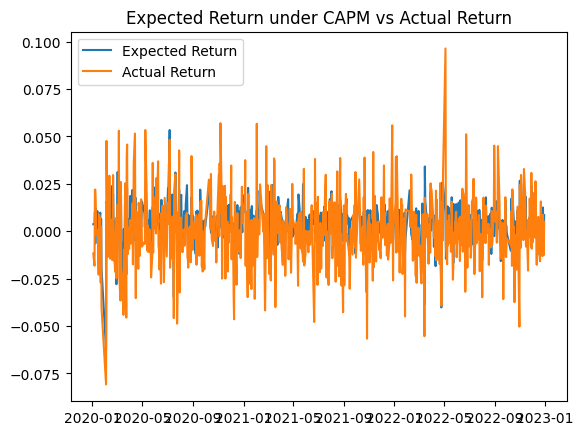

In [51]:
# 画出expected_return和实际的stock_return
import matplotlib.pyplot as plt

plt.title('Expected Return under CAPM vs Actual Return')
plt.plot(expected_return, label='Expected Return')
plt.plot(data_aligned['stock_return'], label='Actual Return')
plt.legend()
plt.show()
